In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import torch
from greedy_models.tree_batch_mono_glm import Tree_Batch_Mono_GLM

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)

In [3]:
T_train = 999 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 500
sub_no = 10
E_no = E_neural.shape[1]
I_no = I_neural.shape[1]
device = torch.device("cuda")

batch_length = 10000
batch_size = 15
iter_no = 9990
epoch_no = iter_no*batch_length*batch_size//T_train 
print(epoch_no)

30


In [4]:
V_train = V[:T_train].to(device)
V_test = V[T_train:T_train + T_test].to(device)

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

In [5]:
train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = Tree_Batch_Mono_GLM(sub_no, E_no, I_no, T_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.98)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

23065


In [7]:
temp_list = np.logspace(0,-3,50)
temp_count = 0

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    temp = temp_list[temp_count]
    if (i%50 == 49) & (temp_count < 49):
        temp_count += 1
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1)
    
    batch_pred, out_filters, C_den, C_syn_e, C_syn_i = model(batch_E_neural,
                                                            batch_I_neural, temp, False)
    loss = torch.var(batch_pred - batch_V)
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if i%50 == 0:
        model.eval()
        test_V_pred, test_out_filters, test_C_den, test_C_syn_e, test_C_syn_i = model(test_E_neural.unsqueeze(0),
                                                            test_I_neural.unsqueeze(0), 0, True)
            
        test_score = metrics.explained_variance_score(y_true=V_test.cpu().detach().numpy(),
                                                      y_pred=test_V_pred.cpu().detach().numpy().flatten())
        print(i, test_score)

<ipython-input-7-58538f5424a2>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.042274144095868715
50 0.4119681011613603
100 -0.05942990443078955
150 0.046493244984415205
200 -0.20691637151434694
250 -0.6778749631049896
300 -0.5391382156650928
350 0.43891053509640154
400 0.5117431992321688
450 0.7463681528400405
500 0.7681226318106971
550 0.6290257046917573
600 0.7272860079749756
650 0.7467154796658467
700 0.7761982776181731
750 0.8013964577339363
800 0.8417229578720863
850 0.8585336168567431
900 0.8711225849204405
950 0.883254400837011
1000 0.8991789363077698
1050 0.8967485966826585
1100 0.90662281561398
1150 0.9066198512559238
1200 0.9151487648750836
1250 0.9221658387034181
1300 0.9213736507531594
1350 0.9321364902459222
1400 0.9340369597545878
1450 0.9373634148025849
1500 0.9384413962783209
1550 0.9425274430285561
1600 0.9362499759528853
1650 0.93947413139207
1700 0.947953190383341
1750 0.9453191780143615
1800 0.9487228144850135
1850 0.944830757792873
1900 0.943473466013689
1950 0.9467063489426543
2000 0.9450122581352193
2050 0.9481663241831366
2100 0.94638

KeyboardInterrupt: 

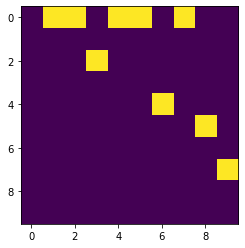

In [8]:
plt.imshow(test_C_den.cpu().detach().numpy())

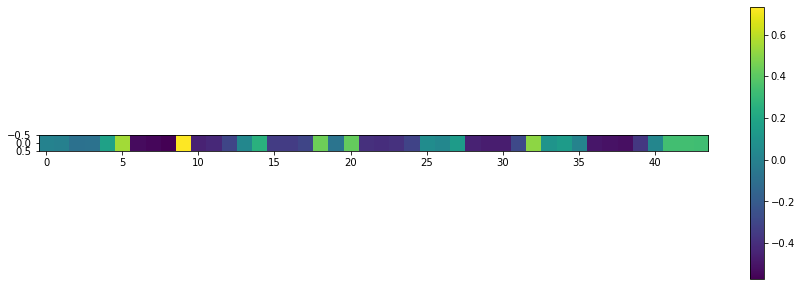

In [9]:
plt.figure(figsize=(15,5))
plt.imshow(model.C_den_raw.cpu().detach().numpy().reshape(1,-1))
plt.colorbar()

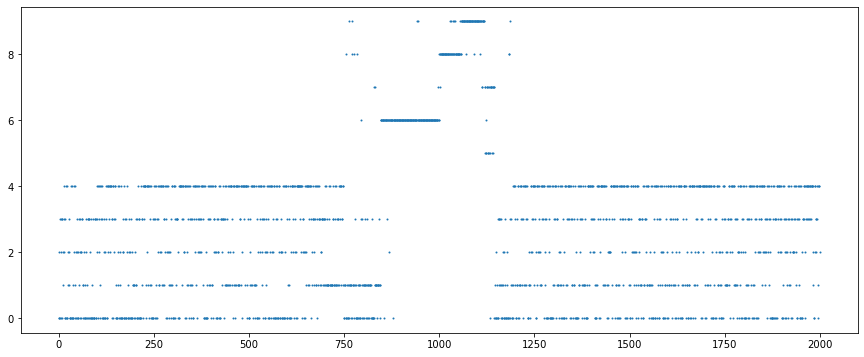

In [10]:
clust = np.zeros((E_no))

for i in range(E_no):
    clust[i] = torch.argmax(test_C_syn_e[:,i])

plt.figure(figsize = (15,6))
plt.scatter(np.arange(E_no), clust, s=1)

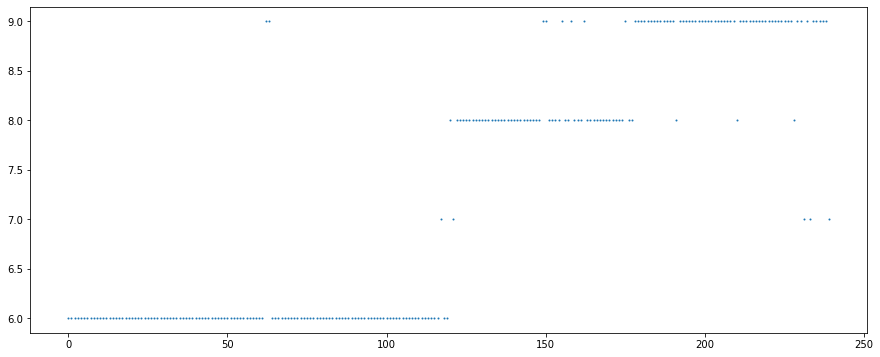

In [11]:
plt.figure(figsize = (15,6))
plt.scatter(np.arange(240), clust[880:1120], s=1)

In [12]:
eloc = np.load("/media/hdd01/sklee/CA1_clust4-60/data/Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy")

peak = np.zeros((E_no, 2))
subunit = np.zeros((E_no, 2))

for i in range(E_no):
    clust_idx = torch.argmax(test_C_syn_e[:,i])
    
    peak[i,0] = torch.argmax(test_out_filters[clust_idx])
    peak[i,1] = eloc[i,0]
    
    subunit[i,0] = clust_idx
    subunit[i,1] = eloc[i,0]


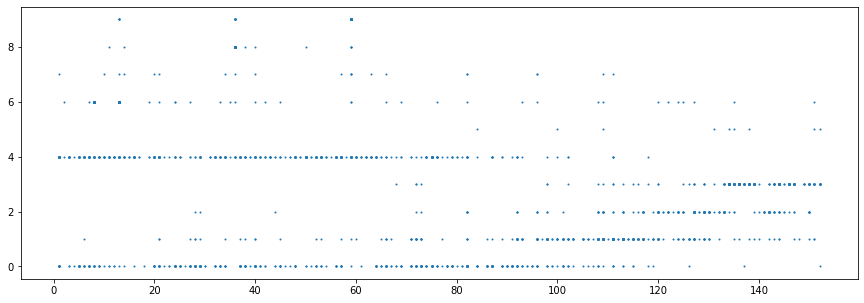

In [13]:
plt.figure(figsize = (15,5))
plt.scatter(subunit[:,1], subunit[:,0], s=1)

In [16]:
print(np.min(eloc[:,0]), np.max(eloc[:,0]))

1.0 152.0


In [19]:
heatmap = np.zeros((152, sub_no))

for i in range(E_no):
    clust_idx = torch.argmax(test_C_syn_e[:,i])
    den_idx = int(eloc[i,0]-1)
    
    heatmap[den_idx, clust_idx] += 1


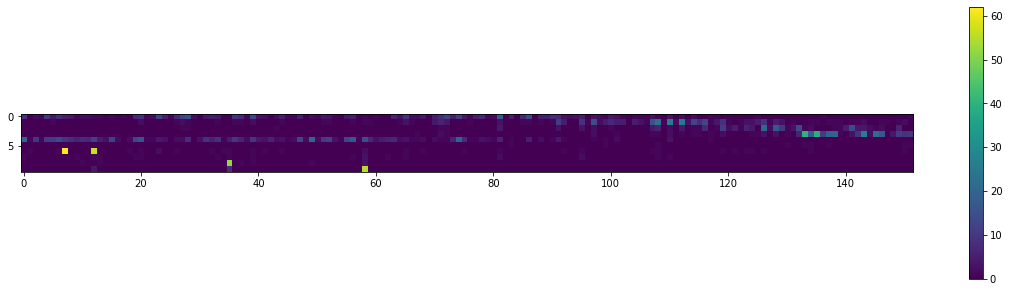

In [25]:
plt.figure(figsize = (20,5))
plt.imshow(heatmap.T)
plt.colorbar()

In [28]:
var_array = np.zeros((10))
for i in range(var_array.shape[0]):
    var_array[i] = np.std(heatmap[:,i])

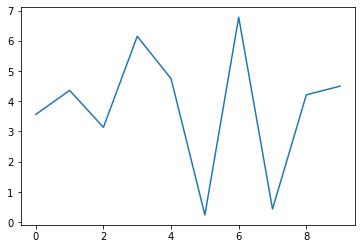

In [29]:
plt.plot(var_array)